In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')
import os

# 3.1.1 Loading Data

In [2]:
full = pd.read_csv('./data/clean/full_data.csv', parse_dates = True, index_col = 0)
elec = pd.DataFrame(full.pop('electricity'))
full = full.join(elec) 

In [3]:
full.head()

,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,month,day,weekday,hour,electricity
timestamp,,,,,,,,,,
2016-01-01 00:00:00,3.8,2.4,1020.9,5,3.1,1,1,5,0,17.7
2016-01-01 01:00:00,3.7,2.4,1021.6,5,2.6,1,1,6,1,37.1
2016-01-01 02:00:00,2.6,1.9,1021.9,0,0.0,1,1,7,2,37.8
2016-01-01 03:00:00,2.0,1.2,1022.3,4,1.5,1,1,1,3,35.1
2016-01-01 04:00:00,2.3,1.8,1022.7,2,1.5,1,1,2,4,27.5


# 3.1.2 Visualizing variable to predict

We see that there are some periods where there is no power consumption. That might be because of a vacational period in which the occupants of the building were out or a malfunction of the meter.

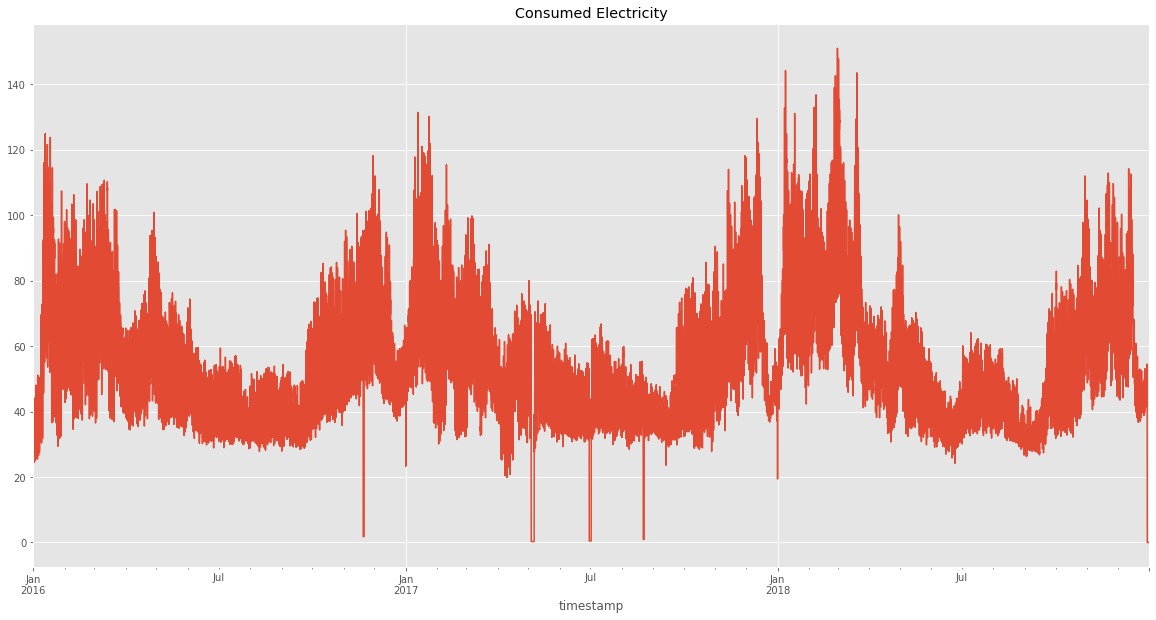

In [4]:
plt.style.use('ggplot')
full['electricity'].plot(title='Consumed Electricity', figsize=(20,10));


# 3.1.3 Data preprocesing

In this part we're going to determine the problem for which we'll train the network model to learn. We frame the problem as a supervised learning adding columns for values for the previous hours and keeping the target columns as the current hour. Therefore, this model will learn to predict the energy consumption being given the previous N = 12 hours of meteorological data as well as previous energy consumption.

The following functions auxiliate on building the input and target vectors.

In [5]:
 # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #df = pd.DataFrame(data)
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(j)) for j in data.columns]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
def weather_supervised(dataframe, n_in, n_out):
    df = dataframe.copy()
    df.pop('electricity')
    return series_to_supervised(data = df, n_in = n_in, n_out = n_out, dropnan=True)

def electric_supervised(dataframe, n_in, n_out):
    elec = pd.DataFrame(dataframe['electricity'])
    elec_sup = series_to_supervised(data = elec, n_in = n_in, n_out = n_out, dropnan=True)
    return elec_sup


In [7]:
electricity = electric_supervised(full, 12, 1)
weather = weather_supervised(full, 12, 0)
full = weather.join(electricity)

#### Data frame with the input vectors and labels

In [8]:
full.head()

,air_temperature(t-12),dew_temperature(t-12),sea_level_pressure(t-12),wind_direction(t-12),wind_speed(t-12),month(t-12),day(t-12),weekday(t-12),hour(t-12),air_temperature(t-11),...,electricity(t-9),electricity(t-8),electricity(t-7),electricity(t-6),electricity(t-5),electricity(t-4),electricity(t-3),electricity(t-2),electricity(t-1),electricity(t)
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 12:00:00,3.8,2.4,1020.9,5.0,3.1,1.0,1.0,5.0,0.0,3.7,...,35.1,27.5,25.2,24.3,25.7,26.9,28.3,34.4,36.6,38.8
2016-01-01 13:00:00,3.7,2.4,1021.6,5.0,2.6,1.0,1.0,6.0,1.0,2.6,...,27.5,25.2,24.3,25.7,26.9,28.3,34.4,36.6,38.8,38.5
2016-01-01 14:00:00,2.6,1.9,1021.9,0.0,0.0,1.0,1.0,7.0,2.0,2.0,...,25.2,24.3,25.7,26.9,28.3,34.4,36.6,38.8,38.5,37.5
2016-01-01 15:00:00,2.0,1.2,1022.3,4.0,1.5,1.0,1.0,1.0,3.0,2.3,...,24.3,25.7,26.9,28.3,34.4,36.6,38.8,38.5,37.5,44.2
2016-01-01 16:00:00,2.3,1.8,1022.7,2.0,1.5,1.0,1.0,2.0,4.0,2.4,...,25.7,26.9,28.3,34.4,36.6,38.8,38.5,37.5,44.2,42.7


Separate data from labels

In [9]:
X = full.iloc[:,:-1]
y = full.iloc[:,-1:]

In [10]:
X.shape, y.shape

((26292, 120), (26292, 1))

Building scalers and normalizing

In [11]:
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

Spliting dataset into training and testing sets

In [12]:
#We split the data into 2/3 of the time for training and 1/3 for testing 
#which would lead to 2 years for training and one year fo testing
train_hours = int(2*full.shape[0]/3)

X_train = X_ss[:train_hours, :]
X_test = X_ss[train_hours:, :]
y_train = y_mm[:train_hours, :]
y_test = y_mm[train_hours:, :]

#to tensors and variables
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

Reshaping input data with the sequential infromation (number of considered rows)

In [13]:
#reshaping to rows, timestamps, features
seq = 1
X_train_tensors_final = torch.reshape(X_train_tensors,   (int(X_train_tensors.shape[0]/seq), seq, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (int(X_test_tensors.shape[0]/seq), seq, X_test_tensors.shape[1])) 

In [14]:
X_train_tensors_final.shape

torch.Size([17528, 1, 120])

# 3.1.4 Building the model

This model consist on a LSTM layer followed by twoo fully conected layers with RELU activation function.

In [15]:
class LSTM_E_1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, num_dir, device):
        super(LSTM_E_1, self).__init__()

        self.device = device
        self.num_classes = num_classes #number of outputs
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.num_directions = num_dir

        if num_dir == 2:
            bi = True
        else: 
            bi = False

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional = bi ) #lstm
        self.fc_1 =  nn.Linear(hidden_size*num_dir, 100) #fully connected 1
        self.fc = nn.Linear(100, num_classes) #fully connected last layer

        self.relu = nn.ReLU() 

    def forward(self,x):
        h_0 = Variable(torch.zeros(
              self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device) #hidden state
        c_0 = Variable(torch.zeros(
            self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device) #internal state

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #print(output.shape)
        out = output.view(-1, self.hidden_size*self.num_directions) #reshaping the data for Dense layer next
        #print(out.shape)
        out = self.relu(out)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        #print(out.shape)
        
        return out 

Create or load model

In [16]:
#checking if there are any saved model checkpoint
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
if os.path.isfile('./data/models/model_1_checkpoint.tar'):
    #load the model
    model = LSTM_E_1(num_classes = 1, input_size = X_train_tensors_final.shape[2], hidden_size=133, num_layers=1, seq_length=X_train_tensors_final.shape[1],  num_dir = 1, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.to(device)
    # Make sure to call input = input.to(device) on any input tensors that you feed to the model

    checkpoint = torch.load('./data/models/model_1_checkpoint.tar', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(model)
    
else:
    model = LSTM_E_1(num_classes = 1, input_size = X_train_tensors_final.shape[2], hidden_size=133, num_layers=1, seq_length=X_train_tensors_final.shape[1],  num_dir = 1, device=device)
    model.to(device)
    print(model)


LSTM_E_1(
  (lstm): LSTM(120, 133, batch_first=True)
  (fc_1): Linear(in_features=133, out_features=100, bias=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)


Determinig loss criterion, optimizer, num_epochs and learning_rate

In [17]:
learning_rate = 0.001 #0.001 lr
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
num_epochs = 1000 #1000 epochs

Epoch: 0, loss: 0.12215, val_loss: 0.12557
Epoch: 50, loss: 0.00238, val_loss: 0.00273
Epoch: 100, loss: 0.00127, val_loss: 0.00175
Epoch: 150, loss: 0.00083, val_loss: 0.00120
Epoch: 200, loss: 0.00065, val_loss: 0.00100
Epoch: 250, loss: 0.00057, val_loss: 0.00092
Epoch: 300, loss: 0.00051, val_loss: 0.00088
Epoch: 350, loss: 0.00048, val_loss: 0.00087
Epoch: 400, loss: 0.00045, val_loss: 0.00088
Epoch: 450, loss: 0.00042, val_loss: 0.00089
Epoch: 500, loss: 0.00040, val_loss: 0.00091
Epoch: 550, loss: 0.00038, val_loss: 0.00093
Epoch: 600, loss: 0.00036, val_loss: 0.00095
Epoch: 650, loss: 0.00034, val_loss: 0.00097
Epoch: 700, loss: 0.00033, val_loss: 0.00099
Epoch: 750, loss: 0.00031, val_loss: 0.00103
Epoch: 800, loss: 0.00030, val_loss: 0.00103
Epoch: 850, loss: 0.00029, val_loss: 0.00107
Epoch: 900, loss: 0.00027, val_loss: 0.00107
Epoch: 950, loss: 0.00026, val_loss: 0.00109


Text(0, 0.5, 'MSE loss')

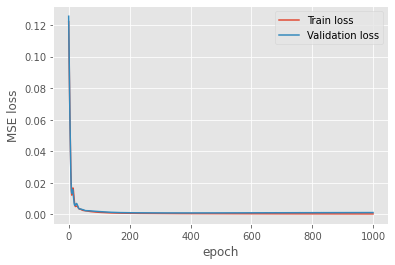

In [21]:
#train 1
model.train()

train_loss = []
val_loss = []
X_test_tensors_final = X_test_tensors_final.to(device)
y_test_tensors = y_test_tensors.to(device)
X_train_tensors_final = X_train_tensors_final.to(device)
y_train_tensors = y_train_tensors.to(device)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
    # obtain the batch loss 
    loss = criterion(outputs, y_train_tensors)
    train_loss.append(loss.item())
    loss.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backpropagation

    #validation
    val_out = model.forward(X_test_tensors_final)
    loss_val =criterion(val_out, y_test_tensors)
    val_loss.append(loss_val.item())

    if epoch % 50 == 0:
    print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, train_loss[epoch], val_loss[epoch])) 

epoch = np.arange(0,num_epochs)

#plotting
plt.plot(epoch, train_loss, label = "Train loss")
plt.plot(epoch, val_loss, label = "Validation loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [ ]:
#to save model you'll have to train/keep training the model
torch.save({
            'epoch': len(epoch),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            }, './data/models/model_1_checkpoint.tar')

# 3.1.5 Validating model

Normalizing

In [18]:
df_X_ss = ss.transform(full.iloc[:,:-1]) #old transformers
df_y_mm = mm.transform(full.iloc[:,-1:]) #old transformers
df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

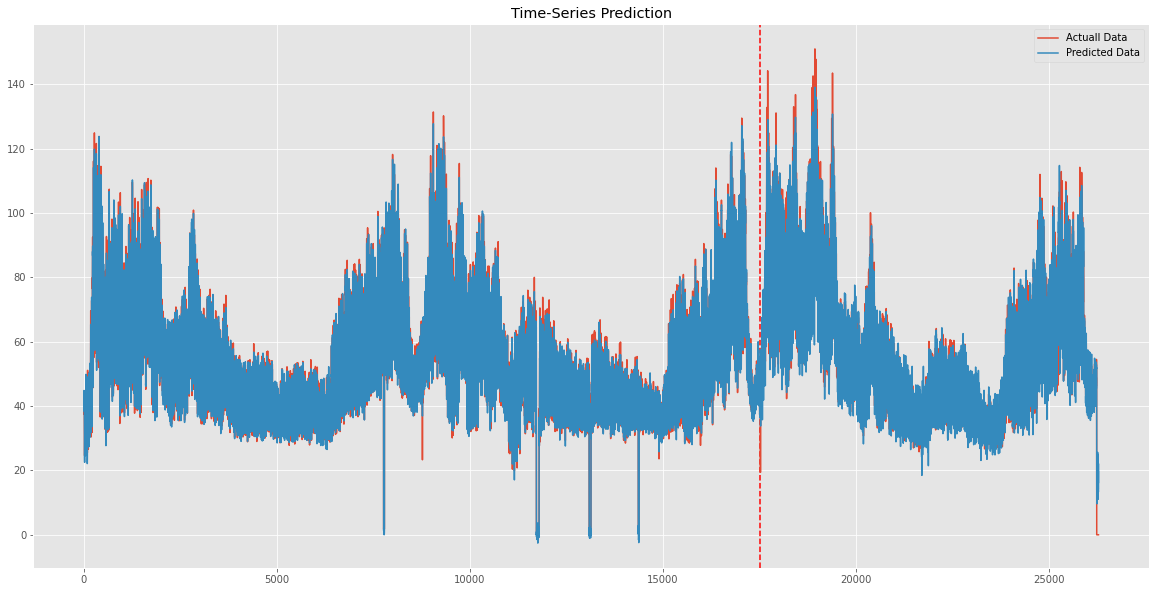

Test RMSE: 3.507


In [19]:
model.eval()

train_predict = model(df_X_ss.to(device))#forward pass
data_predict = train_predict.cpu().data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10)) #plotting
plt.axvline(x=train_hours, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

rmse = np.sqrt(mean_squared_error(dataY_plot, data_predict ))
print('Test RMSE: %.3f' % rmse)

To the left of the dashed veritcal line we have the training data and to the right the testing data. We see that the actual yearly trend seems to have been correctly fitted in the validation set. We'll zoom in in the third year of the data set and compare the actual values vs. the forecasted ones to see how it fits monthly, weekly and daily fluctuations. We see that the squared root of the MSE on the total data set is of 3.507.

In [20]:
Predicted = go.Scatter(x=y[train_hours:].index, y=data_predict[train_hours:].flatten(), opacity = 1, name = 'Forecasted Value', line=dict(color='crimson'), yaxis='y')
Actual = go.Scatter(x=y[train_hours:].index, y=y['electricity(t)'][train_hours:].values, opacity = 0.7, name = 'Actual Value', line=dict(color='royalBlue'), yaxis='y')
layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Predicted, Actual], layout=layout)
fig.show() # if this is rendered in colab, you should run fig.show(renderer='colab') instead.

From the above graph we see that the model sometimes overestimate the electricity consumption and sometimes it is below of the expected. However, we confirm that the average trend is quite good fitted. On a close up we see that it also behaves good enough on predicting when the energy would go up or doow according to the hour of the day, as well as the amplitud of the oscilation during the cold months.

However, this validation feeds the model always with the actual previous values (weather and electricity) without taking into account the forecasted value as part of the previous electricity load information. That would signify that this plot shows how the model performs strictly in the frame of the specified problem (forecast one hour ahead with 12 previous ACTUAL values). In that matter, the model behaves sufficiently well.

## Load forecast using predicted values as input values

Once the model has been trained to make hourly predictions, we'll define a function to predict the energy consumption N hours ahead the last inputed data. We'll be inputing the forecasted values in the historic values in order to consider them for the future forecasts. We'd expect that the error of the forecast value sums up causing the forecast values to drift away from the actual values.

In [21]:
full = pd.read_csv('./data/clean/full_data.csv', parse_dates = True, index_col = 0)
elec = pd.DataFrame(full.pop('electricity'))
full = full.join(elec) 

In [22]:
prev_fut = full.iloc[-1596:-1476,:] #amount of hours equivalent to 4 days

In [23]:
def daily_consumption_forecast_1(previous_df):
    '''
    Takes previous day weather and electrical load information and predicts next day load profile
    '''
    actual_val = pd.DataFrame(data = previous_df.values, columns = previous_df.columns, index = previous_df.index)
    y_predic = []
    for i in range(previous_df.shape[0]-12):
        #filter out from data frame the 12+1 values which will be used
        #to generate the input tensor. This includes the last predicted value.
        previous = previous_df.iloc[i:i + 13,:]
        #prepare and generate input array
        electricity = electric_supervised(previous, 12, 1)
        weather = weather_supervised(previous, 12, 0)
        in_previous = weather.join(electricity)
        # select inputs and targets
        X_previous = in_previous.iloc[:,:-1]
        y_previous = in_previous.iloc[:,-1:]
        #normalization
        X_val = ss.transform(X_previous)
        y_val = mm.transform(y_previous) 
        #from array to tensors and variables
        X_val_tensors = Variable(torch.Tensor(X_val))
        y_val_tensors = Variable(torch.Tensor(y_val))
        #reshape input tensor
        seq = 1
        X_val_tensors_final = torch.reshape(X_val_tensors,   (int(X_val_tensors.shape[0]/seq), seq, X_val_tensors.shape[1]))
        #forward pass
        model.eval()
        y_pred = model.forward(X_val_tensors_final.to(device))
        #reverse normalization
        y_predict = y_pred.cpu().data.numpy() #numpy conversion
        y_predict = mm.inverse_transform(y_predict)
        #add to dataframe the calculated value for the next hour
        aux = previous['electricity'].values.tolist()
        aux[12] = y_predict.item()
        y_predic.append(y_predict.item())
        previous_df.iloc[i:i + 13,:]['electricity'] = aux

    prediction = pd.DataFrame(data = previous_df.values, columns = previous_df.columns, index = previous_df.index)

    return prediction, actual_val, y_predic

In [24]:
pd.options.mode.chained_assignment = None
pred,act, y_f = daily_consumption_forecast_1(prev_fut)

In [25]:
Predicted = go.Scatter(x=act.iloc[12:,:].index, y=np.array(y_f), opacity = 0.7, name = 'Forecasted Value', line=dict(color='crimson'), yaxis='y')
Actual = go.Scatter(x=act.index, y=act['electricity'].values, opacity = 0.7, name = 'Actual Value', line=dict(color='royalBlue'), yaxis='y')
layout = go.Layout(title='Electricity Forecasting', xaxis=dict(title='Hour'),
                   yaxis=dict(title='kBTU', overlaying='y'),
                  yaxis2=dict(title='kBTU', side='right'))
fig = go.Figure(data=[Actual, Predicted], layout=layout)
fig.show() # if this is rendered in colab, you should run fig.show(renderer='colab') instead.

We can see that just by feeding 12 hours of real data to the model, we can obtain a close enough forecast of the electrciity load. We do observe that the further the forecast goes, the prediction separates from the actual curve. The daily patterns remained throug several hours of data being given the predicted values.

In the next model, we'll use a slightly different data preparation, feeding the system with 24 hours of previous data in order to forecast the next 6 hours with a more robust LSTM model.

-----